## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
from numba           import njit
from multiprocessing import Pool

## Test amplitude distribution

Test amplitude shape:
* uphill: slope is $1.6$, starting at $P=0, E=9.5 \Rightarrow P = 1.6\left(E - 9.5\right)$
* downhill: slope is $-0.25$, starting at $P=1 \Rightarrow E_0 = \frac{1.0}{1.6} + 9.5, P = 1.0 - 0.25 \left( E - E_0 \right)$

In [2]:
E_test = np.linspace(0, 15, 1000)
E_0 = 1.0/1.6 + 9.5
P_test = np.zeros(1000)
P_test = 1.6*(E_test - 9.5)
P_test[E_test >= E_0] = (1.0 - 0.25 * (E_test - E_0))[E_test >= E_0]
P_test[P_test < 0] = 0

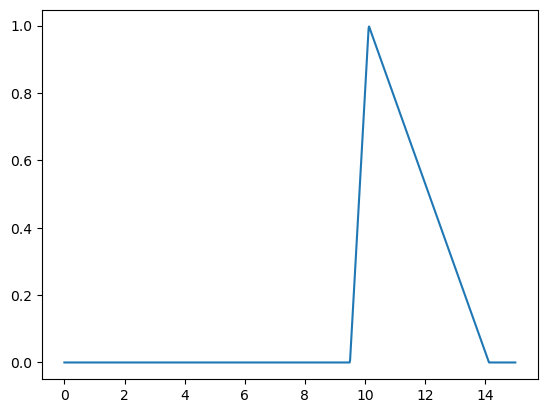

In [3]:
plt.plot(E_test, P_test)

## Probability distribution normalization

In [4]:
"""
\brief Normalize probability distribution

Makes it so that \int PdE = 1

Returns new P
"""
def probNormalize(E, P):
    # Integrate P
    PInt = 0
    for i in range(len(E) - 1):
        PInt += (P[i] + P[i+1]) * (E[i+1] - E[i]) / 2
    return P/PInt

##### Demo

In [5]:
P_test = probNormalize(E_test, P_test)
assert(np.allclose(P_test, probNormalize(E_test, P_test)))

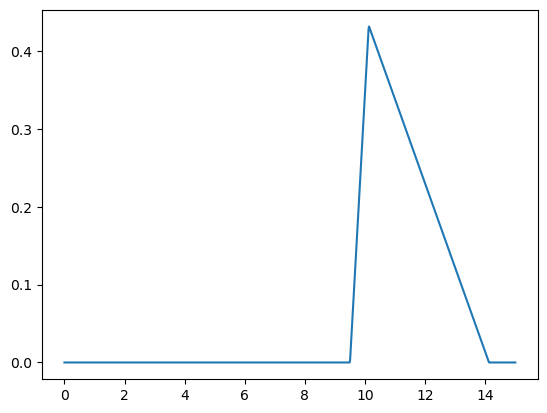

In [6]:
plt.plot(E_test, P_test)

## Load the example signal

The signals are loaded into a tuple where first element is $X$ axis and the second one is $Y$.

In [7]:
exampleSignal = ( [], [] )
with open('task/Shape_Etalon.txt') as exampleSignalFile:
    for line in exampleSignalFile.readlines():
        point = line.split('\t')
        for i in range(2):
            exampleSignal[i].append(float(point[i]))
exampleSignal = (
    np.array(exampleSignal[0]),
    np.array(exampleSignal[1])
)

### Utility: plot the signal

In [8]:
"""
\brief Draws an arbitrary amount of signals on the same plot

All arguments are treated as signals in format described above.
Keyword arguments use their keywords as plot titles
"""
def plotSignals(*signals, **namedSignals):
    for idx, signal in enumerate(signals):
        plt.plot(signal[0], signal[1], label=f"Signal {idx}")
    for name, signal in namedSignals.items():
        plt.plot(signal[0], signal[1], label=name)
    plt.legend()

##### Demo

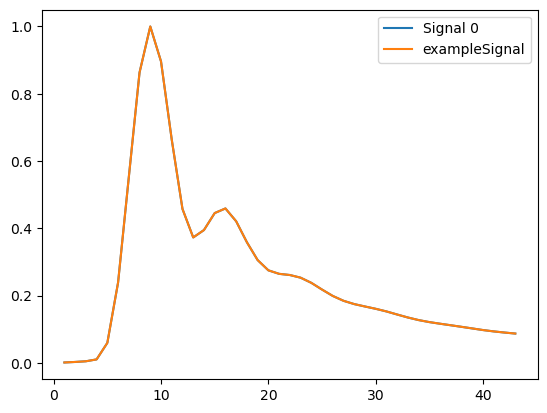

In [9]:
plotSignals(exampleSignal, exampleSignal=exampleSignal)

## Signal composition

We want to perform a linear composition (overlap) of two signals with offset:
$$
S(t) = A_1 S_1\left(t\right) + A_2 S_2\left(t - \tau\right)
$$

In [10]:
"""
\brief Performs a composition of signals

\param signal1 - first signal
\param signal2 - second signal
\param offset  - offset of the second signal relative to the first one
\param amp1    - first signal multiplier
\param amp2    - second signal multiplier

\throws RuntimeError if signal grids aren't aligned
"""
@njit
def composeSignals(
    signal1, signal2,
    offset,
    amp1, amp2
):
    signal = ( signal1[0].copy(), signal1[1].copy() * amp1 )
    for E2 in signal2[0]:
        index2 = np.where(signal2[0] == E2)[0][0]
        E1 = E2 + offset
        if E1 in signal1[0]:
            index1 = np.where(signal[0] == E1)[0][0]
            signal[1][index1] += signal2[1][index2] * amp2
        elif E1 >= np.min(signal1[0]) and E1 <= np.max(signal1[0]):
            raise RuntimeError("Signal grids aren't aligned")
    
    return signal

##### Demo

In [11]:
exampleSignalWithOffset = composeSignals(
    exampleSignal, exampleSignal,
    13, 1, 1
)

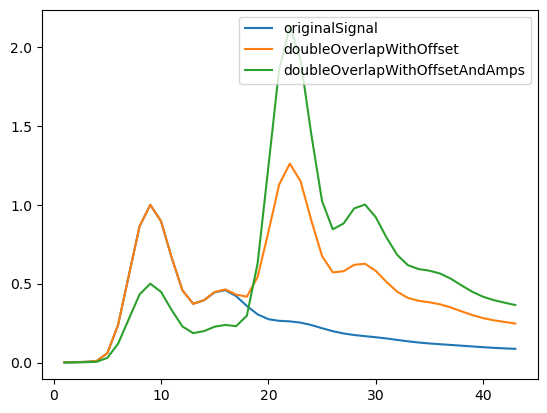

In [12]:
plotSignals(
    originalSignal=exampleSignal,
    doubleOverlapWithOffset=exampleSignalWithOffset,
    doubleOverlapWithOffsetAndAmps=composeSignals(
        exampleSignal, exampleSignal, 13, .5, 2
    )
)

## Integrate the composed signal

Here "inregration" means a sum of all the $Y$ axis values.
We assume that the $X$ axis grid is uniform.

In [13]:
"""
\brief "Integrates" the given signal in the interval

Integration is performed by summing signal's `Y` values

\param signal  - given signal
\param intFrom - _absolute_ left integration boundary
\param intTo   - _absolute_ right integration boundary
"""
@njit
def integrateSignal(signal, intFrom, intTo):
    return np.sum(
        signal[1][
            np.logical_and(
                signal[0] >= intFrom,
                signal[0] <= intTo
            )
        ]
    )

"""
\brief "Integrates" the given signal in the interval
       given via offests relative to the point
       
\param signal      - given signal
\param offsetLeft  - left integration boundary offset relative to the center.
                     Same as intLeft = center - offsetLeft
\param offsetRight - right integration boundary offset relative to the center.
                     Same as intRight = center + offsetRight
\param center      - A point inside integration interval that offsets relate to
"""
@njit
def integrateSignalRelative(signal, offsetLeft, offsetRight, center = 9):
    return integrateSignal(signal, center - offsetLeft, center + offsetRight)

## Roll signal amplitude

In [14]:
"""
\brief Rolls a random value with a given probability distribution

Assumes distribution defined by `P`, `E` is normalized
"""
@njit
def rollAmp(P, E):
    # Integrate probability density to get probability
    Pint = 0
    PintArr = np.full_like(P, 0)
    # assert(P[0] == 0)
    for i in range(1, len(P)): # Len preserves interoperability with Python arrays
        PintArr[i] = PintArr[i - 1] + P[i] * (E[i] - E[i - 1])
    # assert(np.isclose(PintArr[-1], 1))
    
    roll = np.random.uniform(0, 1, 1)[0] # Random roll
    
    # Convert our uniform roll into a random number, interpolate
    lowerIdx = np.where(PintArr <= roll)[0][-1]
    upperIdx = np.where(PintArr >= roll)[0][0]
    # assert(lowerIdx + 1 == upperIdx)
    
    t = (roll - PintArr[lowerIdx]) / (PintArr[upperIdx] - PintArr[lowerIdx])
    return E[lowerIdx] + t * (E[upperIdx] - E[lowerIdx])

##### Demo

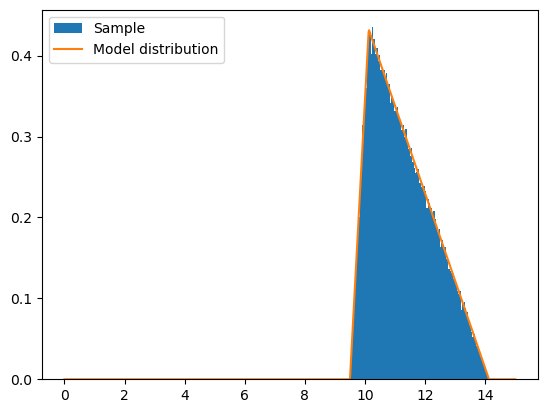

In [15]:
amps = [rollAmp(P_test, E_test) for i in range(100000)]
plt.hist(amps, bins=100, density=True, label='Sample')
plt.plot(E_test, P_test, label='Model distribution')
plt.legend()

## Utility: parallelization

Python parallelization is wierd.
Only toplevel functions are allowed to run in a pool, so we need a hack.

In [16]:
if __name__ == "__main__":
    tasks = []

"""
\brief Runs a task from a task pool

\param idx - index of the task to run
"""
def parallelRunner(idx):
    np.random.seed() # Each thread should have its own random seed
    return tasks[idx]()

"""
\brief Runs in parallel several instances of the function

This function is used to gather staticstics.
It does not pass any index to the function.
All of the runs are identical from the caller standpoint.

\param amount   - final amount of runs
\param poolSize - process pool size. Passed directly to `multiprocessing.Pool`.
                  Set to `None` to use automatic value.
\param what     - a function (or functor) to run
\param args     - function arguments

kwargs aren't supported by numba
"""
def runInParallel(amount, poolSize, what, *args):
    # Clean some of the old tasks
    global tasks
    while len(tasks) > 10:
        del tasks[0]
    
    # Add our task
    idx = len(tasks)
    tasks.append(lambda: what(*args))
    
    # Run threads
    with Pool(poolSize) as pool:
        return pool.map(
            parallelRunner,
            [ idx for i in range(amount) ]
        )

"""
\brief Returns a result of bulk-execution of function

A helper for \ref runInParallelBulk


"""
@njit
def bulkRunnerHelper(bulkSize, what, *args):
    return [ what(*args) for i in range(bulkSize) ]

"""
\brief Runs a bulk of cheap tasks in parallel

'Cheap' tasks don't benefit from parallelization since the thread
creationg cost exceeds the task cost.
It is still possible to gain the advantage by concurrently running
several sequential executions of such tasks.

kwargs aren't supported by numba

\param bulkNum  - number of tasks to process
\param bulkSize - number of sequential runs of `what` in one task
\param poolSize - see \ref runInParallel
\param what     - see \ref runInParallel
\param args     - see \ref runInParallel

Total amount of runs equals `bulkNum * bulkSize`
"""
def runInParallelBulk(bulkNum, bulkSize, poolSize, what, *args):
    return [
        elem for runResult in runInParallel(
            bulkNum, poolSize,
            bulkRunnerHelper, bulkSize, what, *args
        ) for elem in runResult
    ]

##### Demo

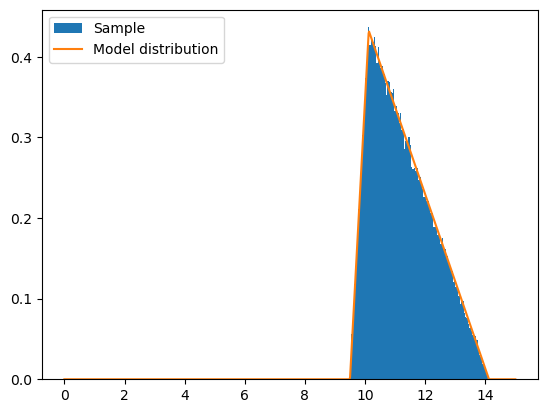

In [17]:
amps = runInParallelBulk(100, 1000, None, rollAmp, P_test, E_test)
assert(len(amps) == 100_000)
plt.hist(amps, bins=100, density=True, label='Sample')
plt.plot(E_test, P_test, label='Model distribution')
plt.legend()

## Complete roll

When doing a complete roll, we need to roll all signals amplitudes and all of the offsets.
Amplitudes distribution is given by `P` and `E`, offset distribution is uniform in the integer interval between $0$ and $42$ (including $0$ and $42$).

In [18]:
"""
\brief Perform a full roll for two-signal overlap

Offset is determined as a uniformly distributed random integer from 0 to 42
Amplitudes are determined as random values with distribution given by `P` and `E`

\param P           - distribution P
\param E           - distribution E
\param signal      - signal shape
\param offsetLeft  - left integration border offset relative to 9
\param offsetRight - right integration border offset relative to 9

See \ref integrateSignalRelative for better explaination of `offsetLeft` and `offsetRight`
"""
@njit
def rollDoubleOverlap(P, E, signal, offsetLeft, offsetRight):
    offset = np.floor(np.random.uniform(0, 43))
    amp1 = rollAmp(P, E)
    amp2 = rollAmp(P, E)
    
    return np.array([
        offset,
        amp1,
        amp2,
        integrateSignalRelative(composeSignals(signal, signal, offset, amp1, amp2), offsetLeft, offsetRight)
    ])

In [19]:
"""
\brief Performs a bulk of two-peak overlap rolls and provides utility functions
"""
class TwoRollTester:
    """
    \brief Initialze runner
    
    \param P, E   - amplitude distribution P, E
    \param signal - signal shape
    """
    def __init__(self, P, E, signal):
        self.P = P
        self.E = E
        self.signal = signal
        self.result = None
    
    """
    \brief Run `numRolls` double overlap simulations
    
    \param offsetLeft  - left border of integration offset relative to 9
    \param offsetRight - right border of integration offset relative to 9
    \param numRolls    - number of rolls
    \param bulkNum     - number of parallel processes
    """
    def run(self, offsetLeft, offsetRight, numRolls=10_000_000, bulkNum=100):
        self.result = {
            "left":  offsetLeft,
            "right": offsetRight,
            "data":  np.array(
                runInParallelBulk(
                    bulkNum, numRolls / bulkNum, None,
                    rollDoubleOverlap,
                    self.P, self.E, self.signal,
                    offsetLeft, offsetRight
                )
            )
        }
    
    """
    \brief Run `numRolls` single signal simulations
    
    \param offsetLeft  - left border of integration offset relative to 9
    \param offsetRight - right border of integration offset relative to 9
    \param numRolls    - number of rolls
    \param bulkNum     - number of parallel processes
    """
    def runSingle(self, offsetLeft, offsetRight, numRolls=10_000_000, bulkNum=100):
        amps = runInParallelBulk(
            bulkNum, numRolls / bulkNum, None,
            rollAmp, self.P, self.E
        )
        self.result = {
            "left":       offsetLeft,
            "right":      offsetRight,
            "dataSingle": np.array(
                [
                    integrateSignalRelative(
                        ( self.signal[0], self.signal[1] * amp ),
                        offsetLeft, offsetRight
                    )
                    for amp in amps
                ]
            )
        }
    
    """
    \brief Creates a plot with the computaion result
    
    \param bins    - number of bins to use
    \param figsize - figsize to use
    \param dump    - file name to dump output histogram to
    \param dumpSep - dump separator
    """
    def plot(self, bins=1001, figsize=(10, 10), dump=None, dumpSep=' '):
        assert(self.result is not None)
        
        hist = None
        
        if "data" in self.result:
            fig, ax = plt.subplots(2, 2, squeeze=True, figsize=figsize)
            for i in range(2):
                for j in range(2):
                    ax[i, j].set_box_aspect(1)

            titleBase = f"Channels {9-self.result['left']}-{9+self.result['right']}"

            hist = ax[0,0].hist(self.result["data"][:,3], bins=bins, density=True)
            ax[0,0].set_title(f"{titleBase}: integral distribution")

            ax[0,1].hist(
                self.result["data"][:,0],
                bins=int(
                    np.max(self.result["data"][:,0])
                    -
                    np.min(self.result["data"][:,0])
                ) + 1
            )
            ax[0,1].set_title(f"{titleBase} - second peak offset distribution")

            ax[1,0].hist(self.result["data"][:,1], bins=bins, density=True)
            ax[1,0].set_title(f"{titleBase} - first peak amplitude distribution")
            ax[1,1].hist(self.result["data"][:,2], bins=bins, density=True)
            ax[1,1].set_title(f"{titleBase} - second peak amplitude distribution")
        elif "dataSingle" in self.result:
            hist = plt.hist(
                self.result["dataSingle"],
                bins=bins,
                label=f"Integrating single signal channels {9-self.result['left']} through {9+self.result['right']}"
            )
            plt.legend()
        
        if hist is not None and dump is not None:
            with open(dump, "w+") as histOutput:
                for n, x in zip(hist[0], hist[1]):
                    histOutput.write(f"{x}{dumpSep}{n}\n")

In [20]:
tester = TwoRollTester(P_test, E_test, exampleSignal)

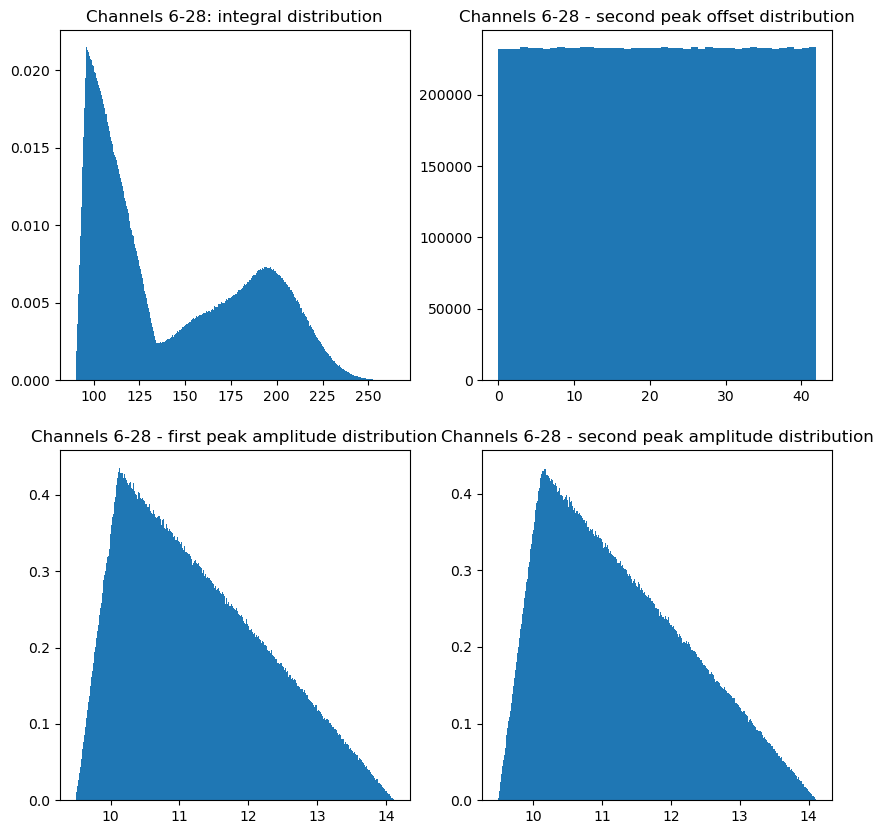

In [21]:
tester.run(3, 19)
tester.plot()

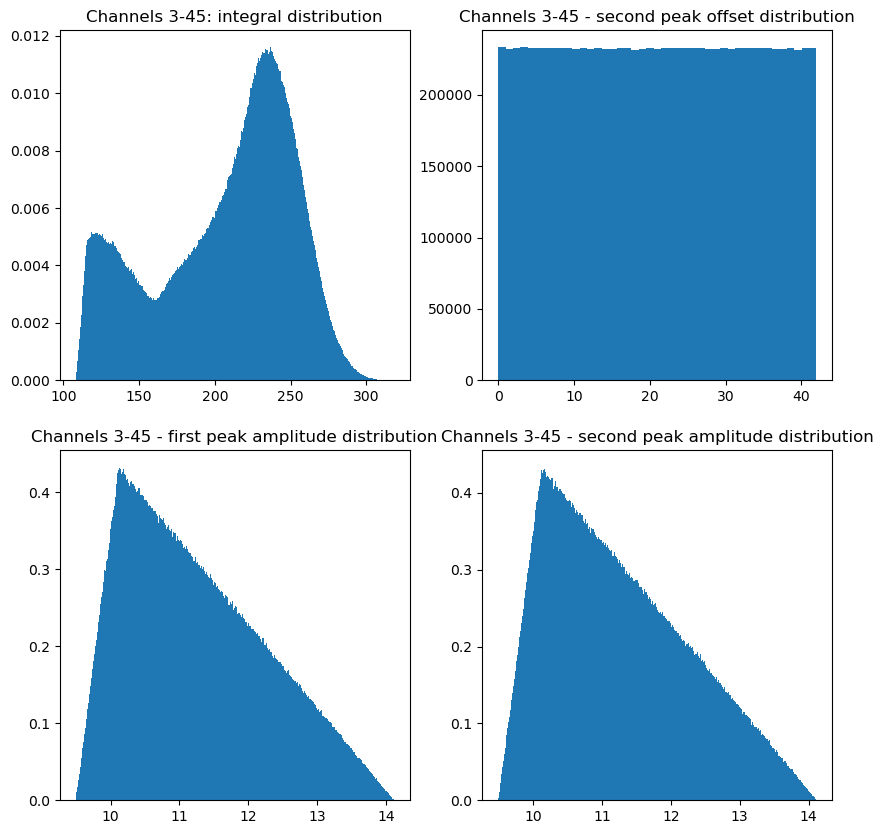

In [22]:
tester.run(6, 36)
tester.plot()

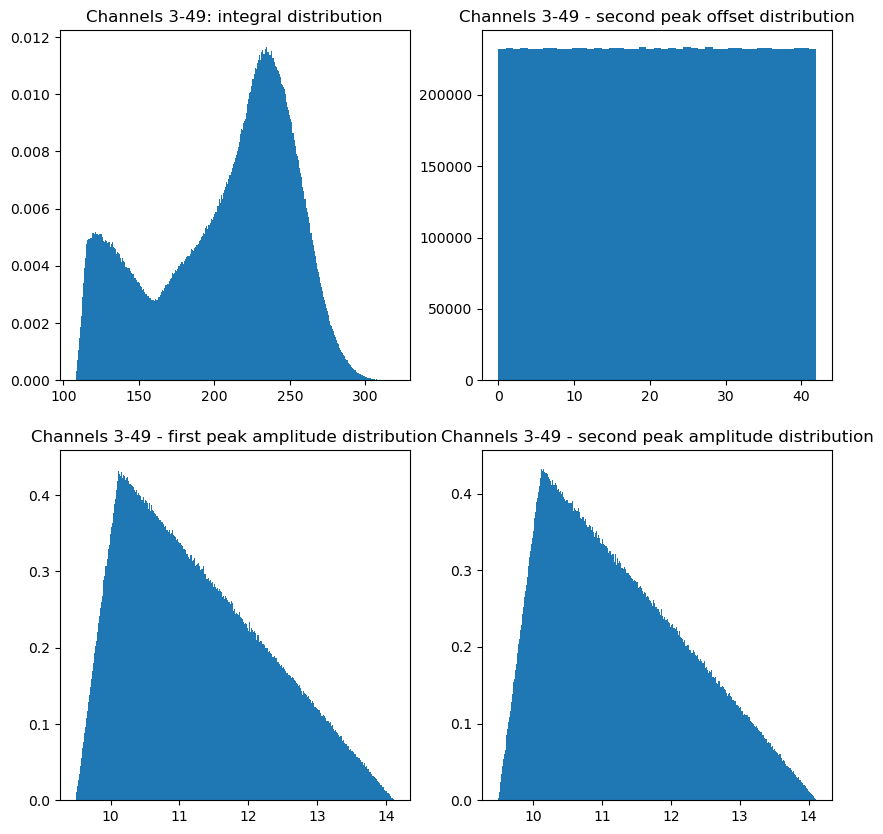

In [23]:
tester.run(6, 40)
tester.plot()

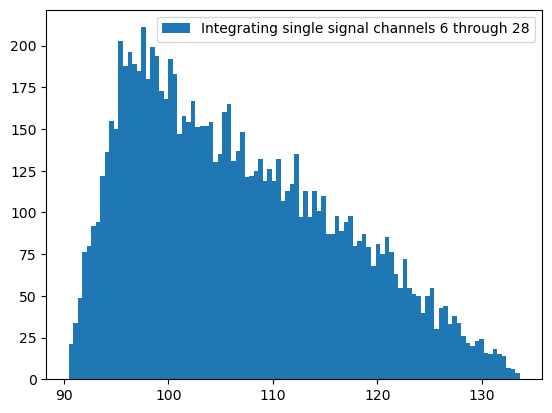

In [24]:
tester.runSingle(3, 19, 10_000)
tester.plot(bins=100)

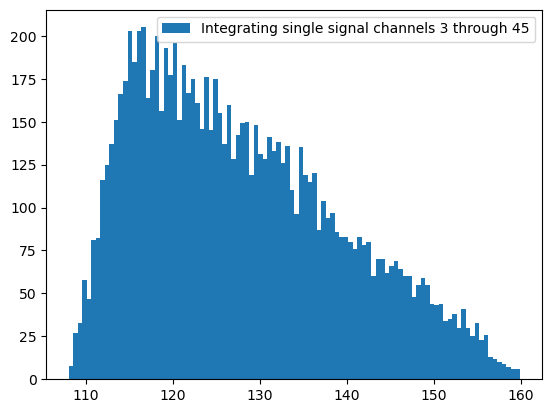

In [25]:
tester.runSingle(6, 36, 10_000)
tester.plot(bins=100)

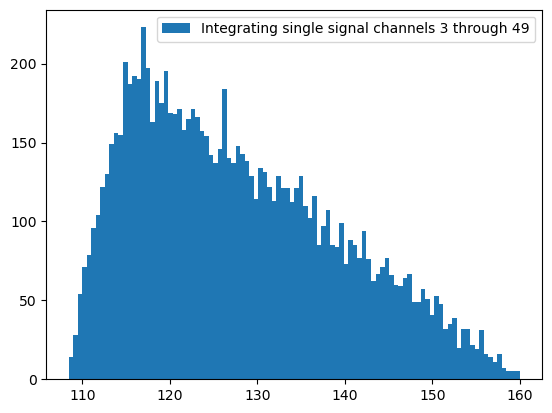

In [26]:
tester.runSingle(6, 40, 10_000)
tester.plot(bins=100)

## Experimental amplitude distribution

### Load signal shapes

In [27]:
"""
\brief Loads a signal shape from Numass experimental data file

Uses tabs by default, changed with `separator`

\param filename  - data file name
\param separator - file column separator
"""
def loadExperimentalSignal(filename, separator='\t'):
    signal = ( [], [] )
    with open(filename) as sigFile:
        header = True
        for line in sigFile.readlines():
            if header:
                header = False
                continue
            
            point = list(
                map(
                    lambda x: float(x) if x else 0,
                    line.split(separator)
                )
            )
            
            signal[0].append(point[0])
            signal[1].append(sum(point[1:]))
    
    return ( np.array(signal[0]), probNormalize(np.array(signal[0]), np.array(signal[1])) )

12000
12500
13000
13500


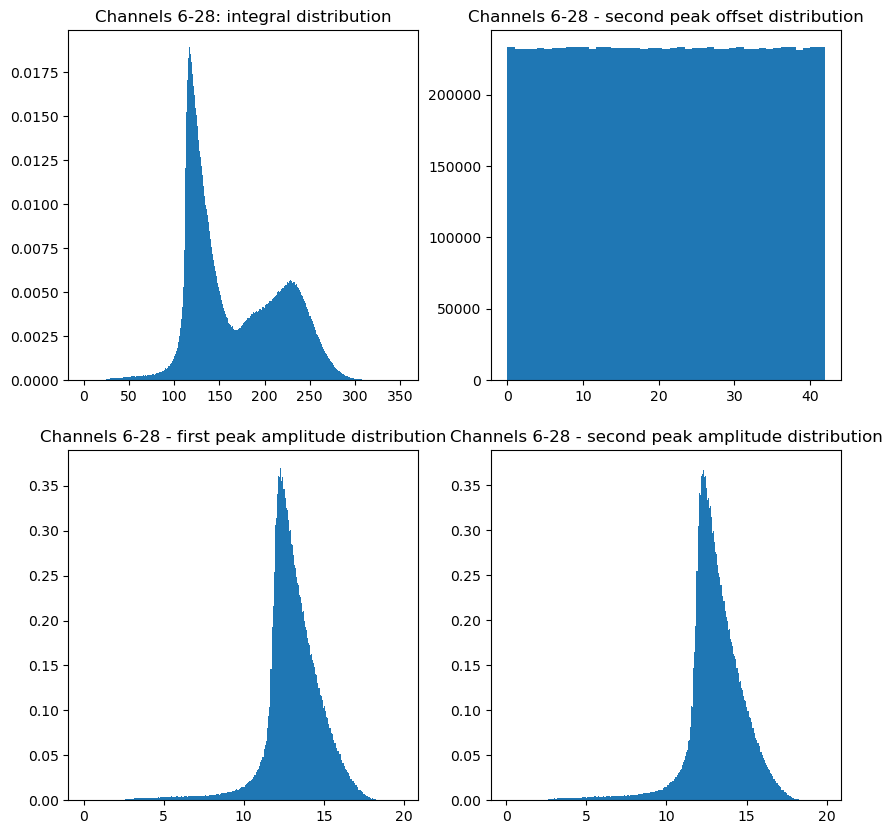

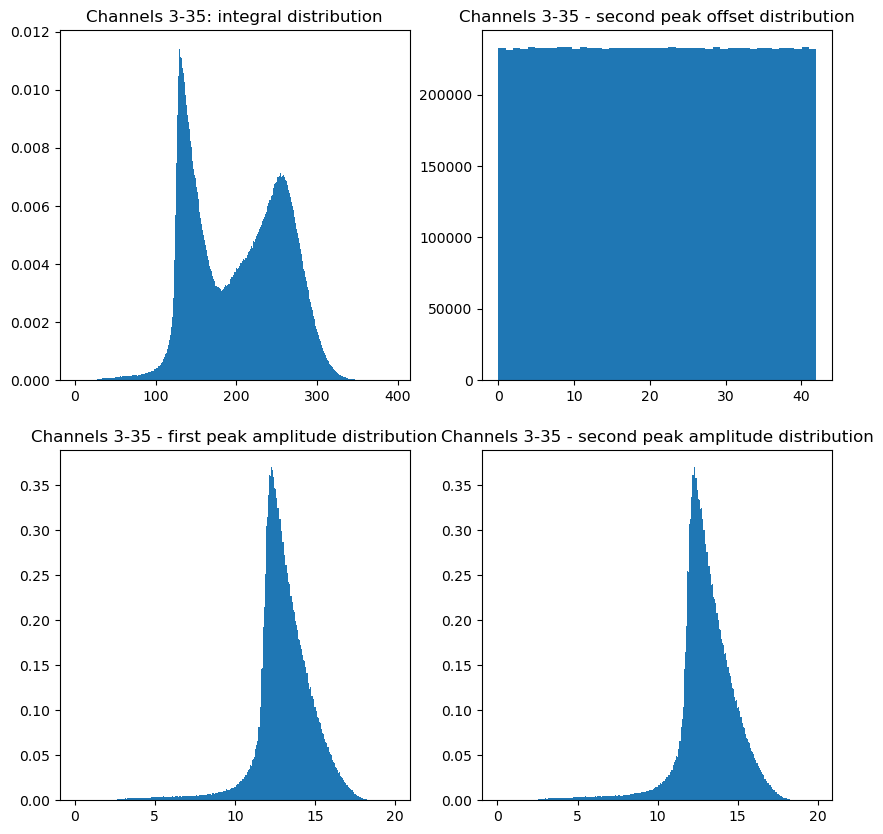

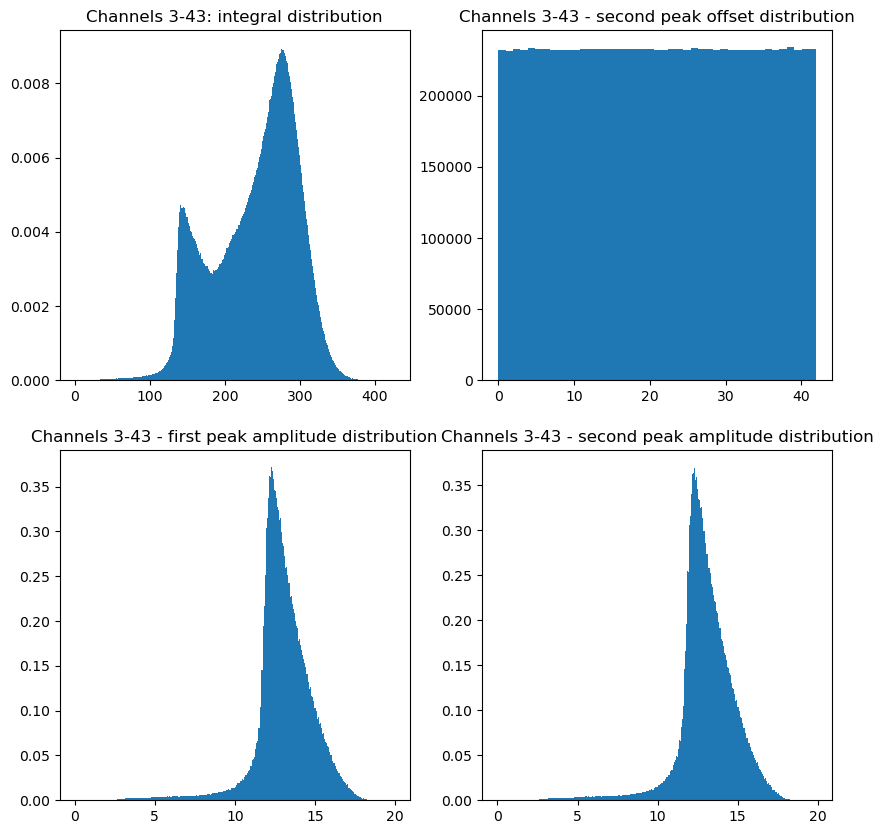

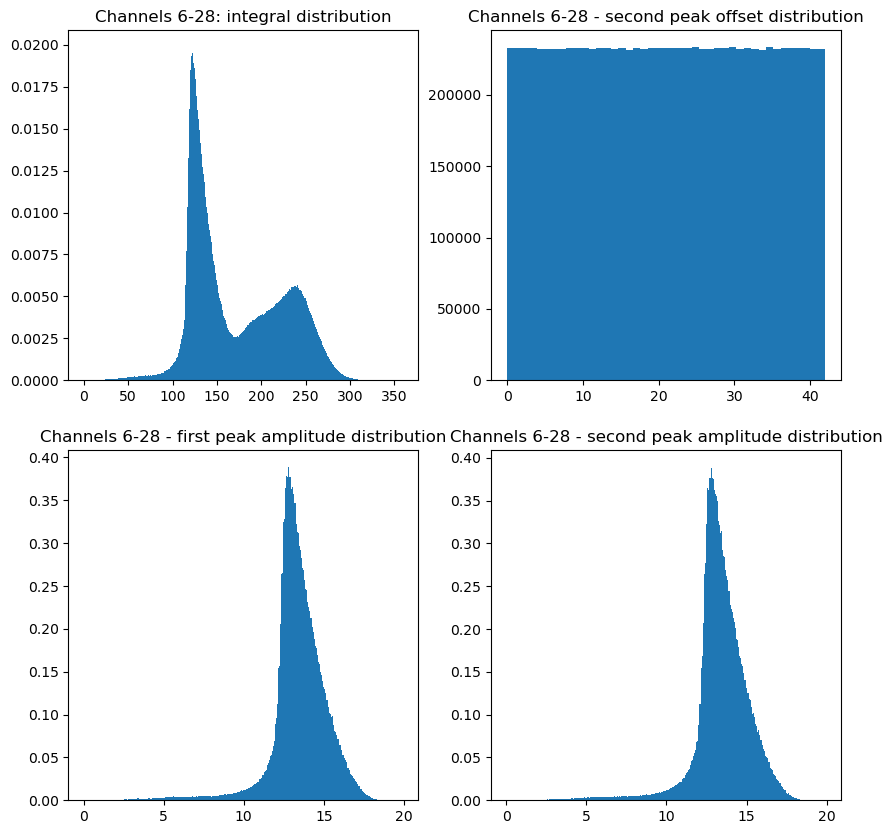

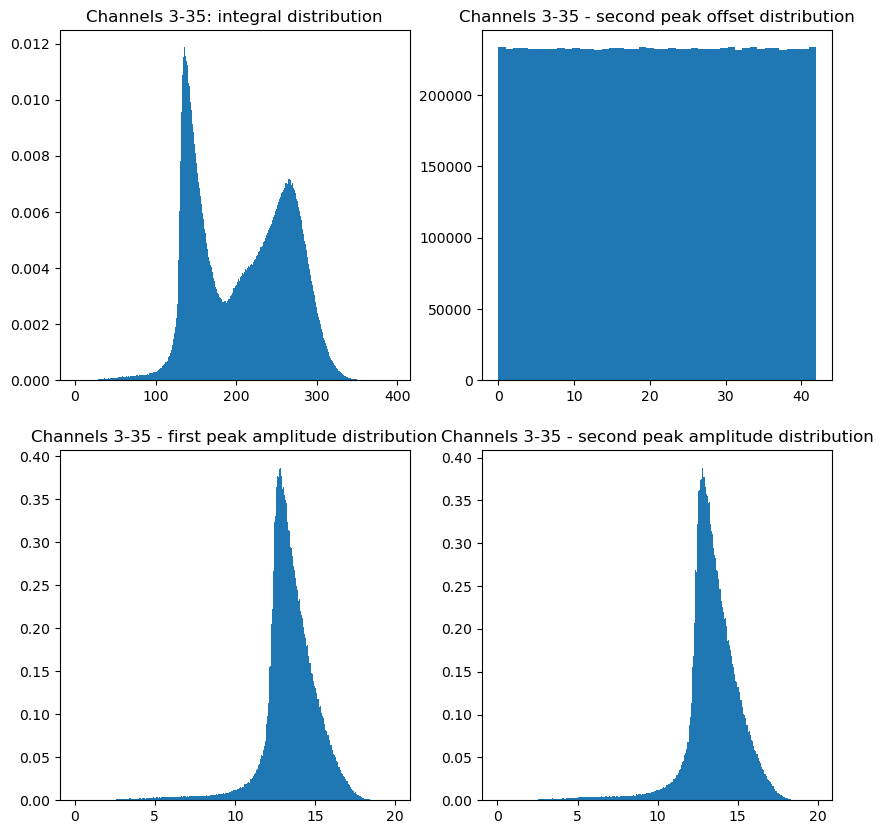

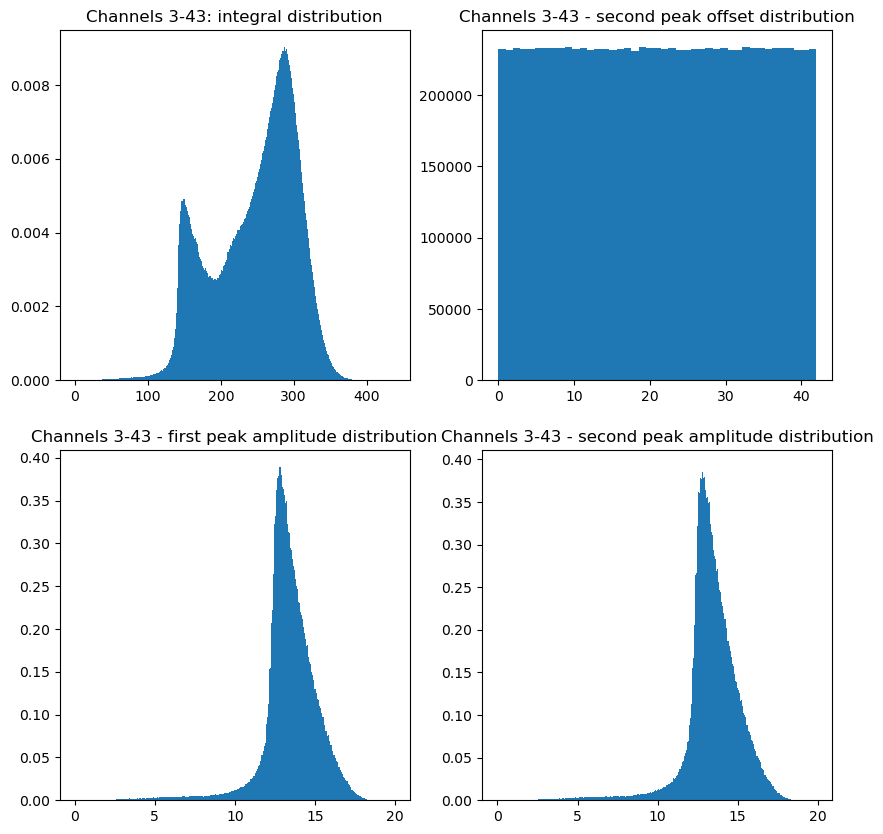

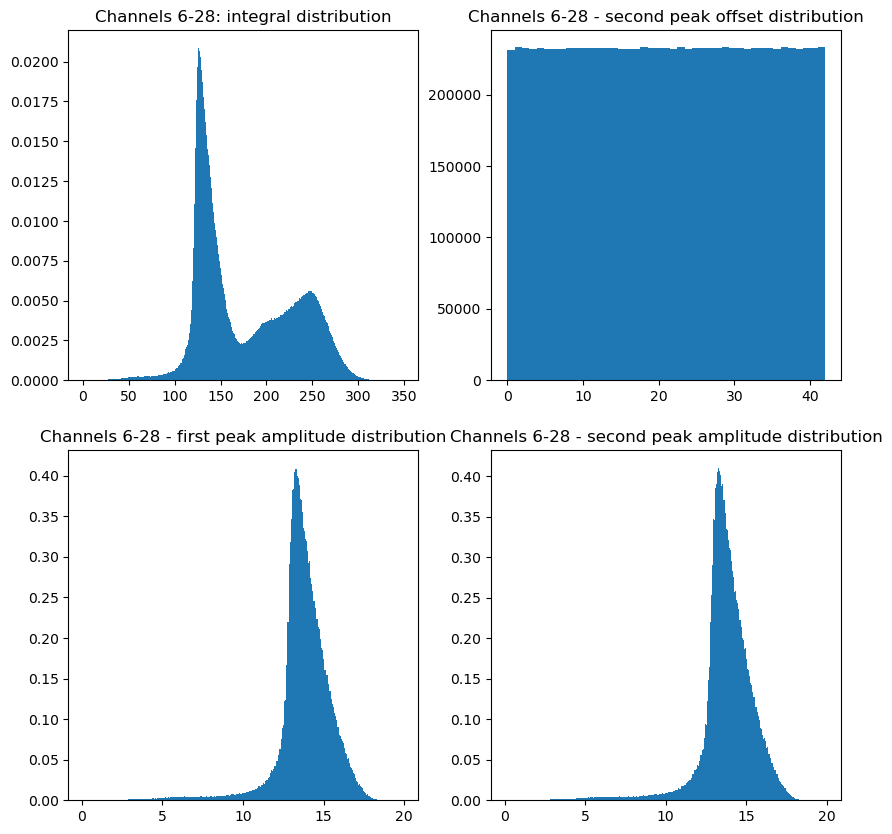

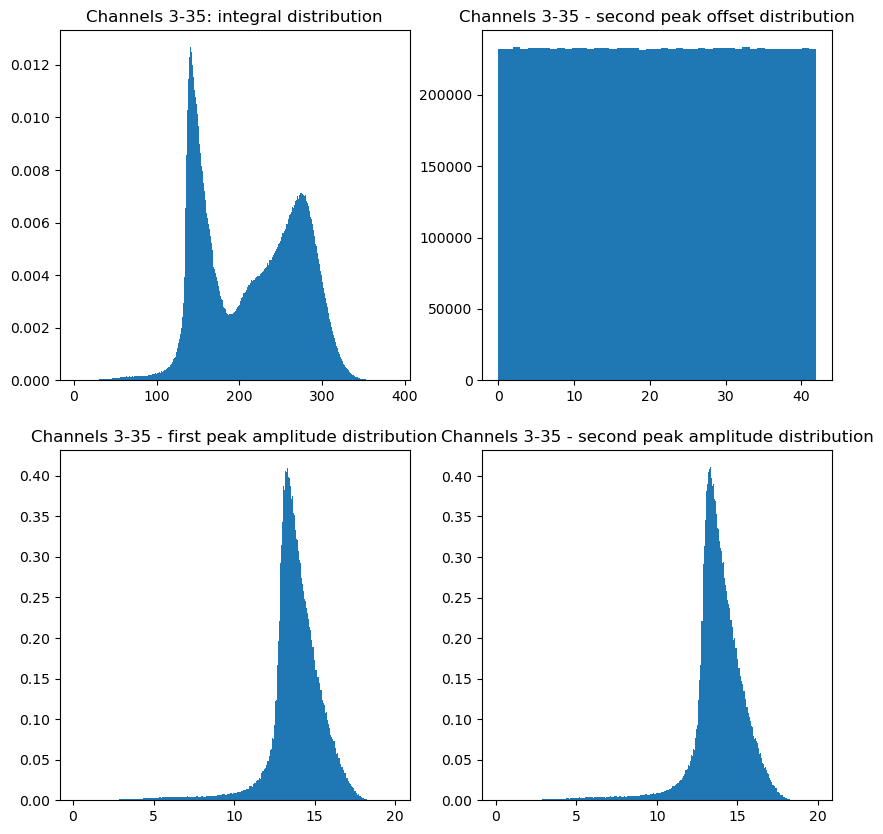

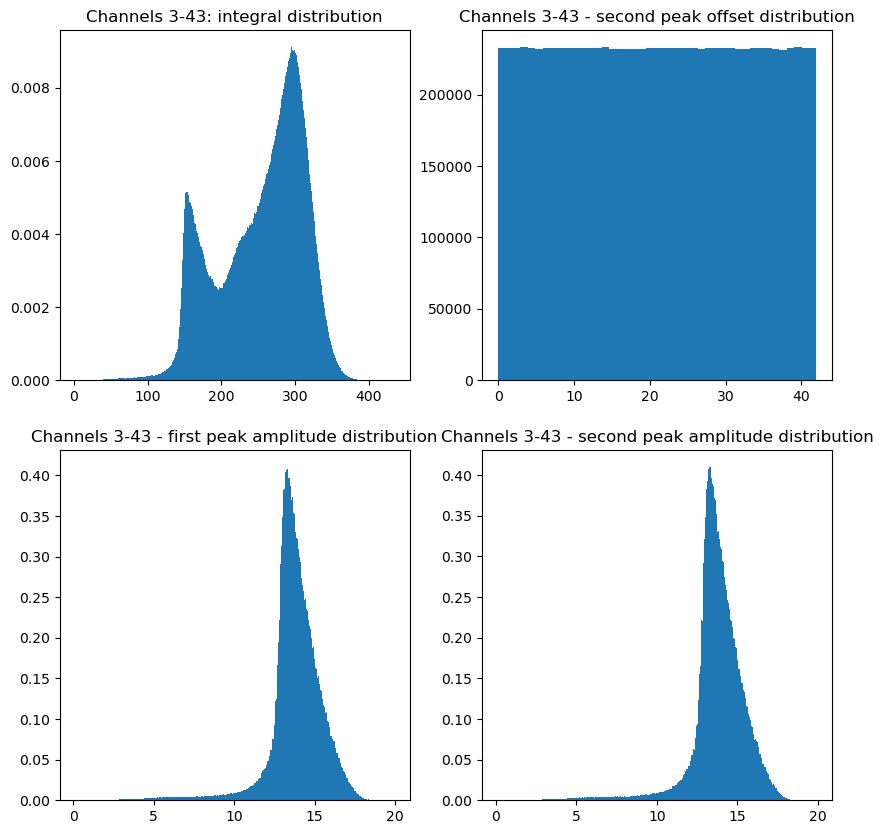

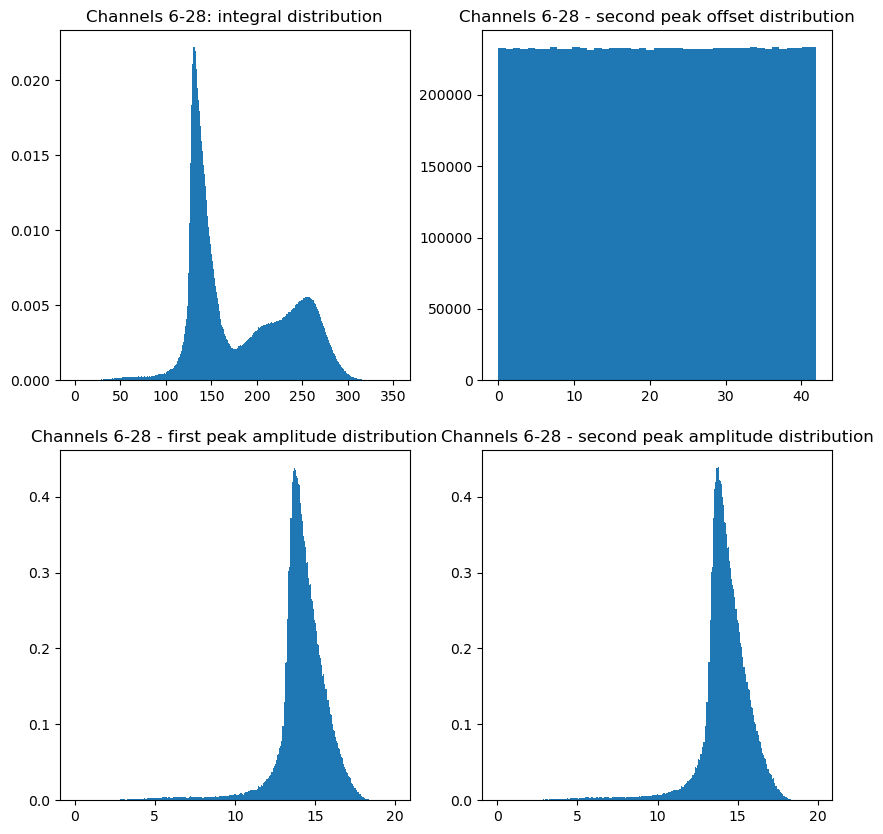

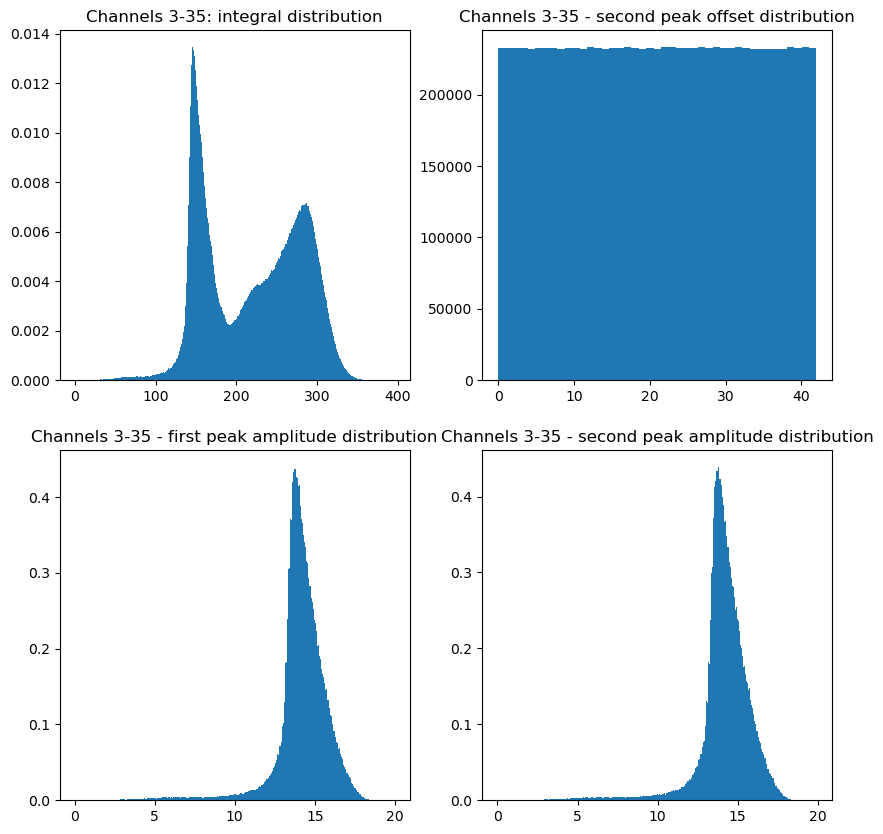

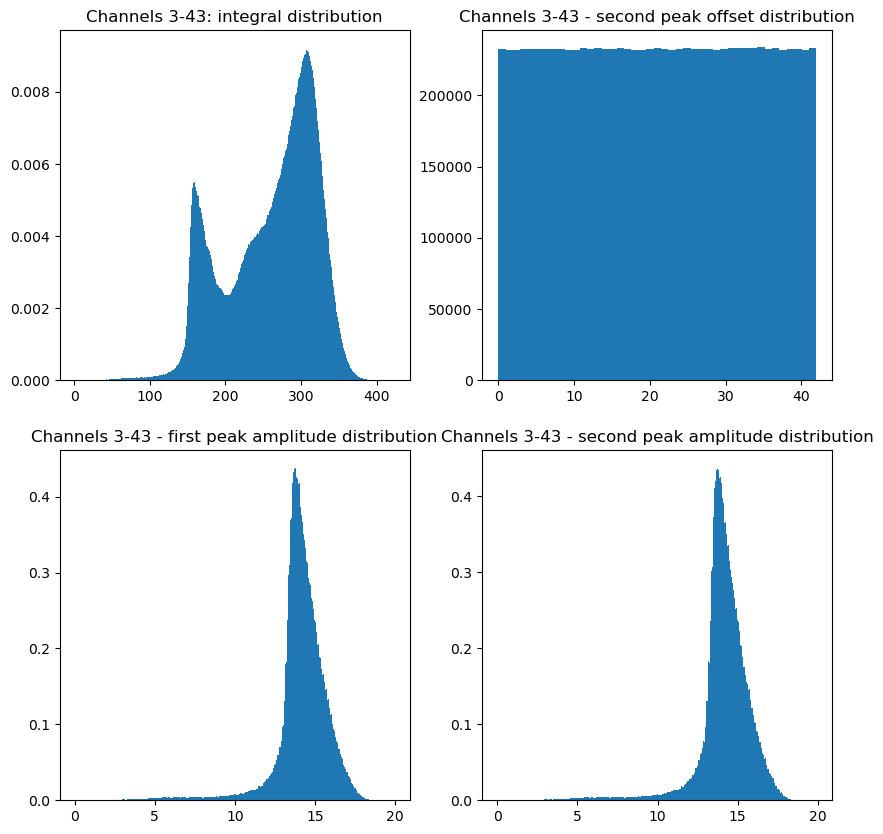

In [29]:
for pn, num in [
    ( "120", "12000"),
    ( "109", "12500"),
    ( "98", "13000"),
    ( "87", "13500"),
#    ( "121", "14000" )
]:
    print(num)
    
    hvprob = loadExperimentalSignal(f"task/data/p{pn}(30s)(HV1={num}).txt")
    assert(np.allclose(hvprob[1], probNormalize(hvprob[0], hvprob[1])))

    hv = TwoRollTester(
        hvprob[1], hvprob[0],
        exampleSignal
    )
    hv.run(3, 19)
    hv.plot(dump=f"task/output/{num}_3_19.txt")
    hv.run(6, 26)
    hv.plot(dump=f"task/output/{num}_6_26.txt")
    hv.run(6, 34)
    hv.plot(dump=f"task/output/{num}_6_34.txt")

In [30]:
"""
\brief Reads a histogram file and determines how many matches hit left or right of the border

\param filename  - histogram file name
\param border    - border
\param separator - column separator
"""
def analyzeHistFile(filename, border, separator=' '):
    with open(filename) as histFile:
        left = 0
        right = 0
        
        for line in histFile.readlines():
            if line == "":
                continue
            
            point = line.split(separator)
            
            if float(point[0]) < border:
                left += float(point[1])
            else:
                right += float(point[1])
        
        return (left, right)

In [31]:
analyzeHistFile("task/output/12000_3_19.txt", 178)

(1.7229599112850722, 1.1200679843436252)